In [ ]:
#Connecting to the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data import AUTOTUNE

# Set path to your dataset
data_dir = '/content/drive/MyDrive/chest_xray (1)'

#Resizing image and configuring batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load training data
train_ds = image_dataset_from_directory(
    directory=f"{data_dir}/train",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

#Load validation data
val_ds = image_dataset_from_directory(
    directory=f"{data_dir}/val",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Load test data
test_ds = image_dataset_from_directory(
    directory=f"{data_dir}/test",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Prefetch batch for optimized performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 6818 files belonging to 2 classes.
Found 1172 files belonging to 2 classes.
Found 586 files belonging to 2 classes.


In [ ]:
# Optimize
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
def build_simple_cnn():
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


In [ ]:
simple_cnn = build_simple_cnn()
simple_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

simple_cnn_history = simple_cnn.fit(train_ds, validation_data=val_ds, epochs=5)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 1161s 5s/step - accuracy: 0.7805 - loss: 0.8575 - val_accuracy: 0.9300 - val_loss: 0.1752
Epoch 2/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 88s 402ms/step - accuracy: 0.9569 - loss: 0.1158 - val_accuracy: 0.9070 - val_loss: 0.2721
Epoch 3/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 142s 403ms/step - accuracy: 0.9793 - loss: 0.0540 - val_accuracy: 0.9172 - val_loss: 0.2870
Epoch 4/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 86s 403ms/step - accuracy: 0.9943 - loss: 0.0218 - val_accuracy: 0.9292 - val_loss: 0.3345
Epoch 5/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 143s 404ms/step - accuracy: 0.9980 - loss: 0.0070 - val_accuracy: 0.9317 - val_loss: 0.3172


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Get predicted probabilities
y_probs = simple_cnn.predict(test_ds)
y_pred = (y_probs > 0.5).astype("int").flatten()


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step


In [ ]:
# Accuracy
print(f"Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))


Accuracy: 91.64%

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.94      0.89      0.91       293
   PNEUMONIA       0.89      0.95      0.92       293

    accuracy                           0.92       586
   macro avg       0.92      0.92      0.92       586
weighted avg       0.92      0.92      0.92       586



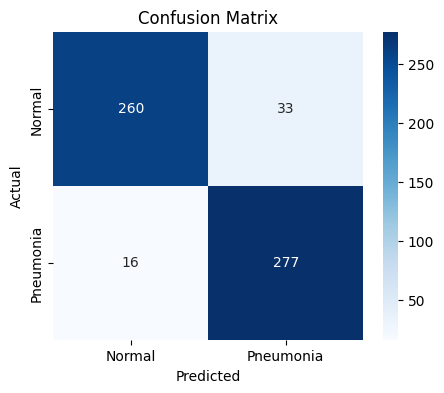

In [ ]:
#confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
#AUC
auc = roc_auc_score(y_true, y_probs)
print(f"AUC Score: {auc:.4f}")


AUC Score: 0.9800


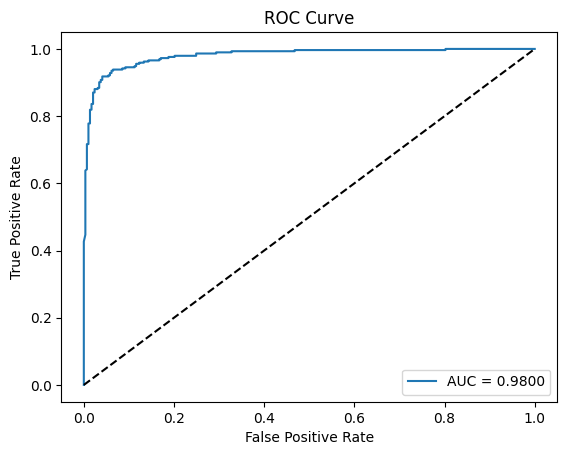

In [ ]:
from sklearn.metrics import roc_curve
#ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
